# Errors in serial dilution: How can dispensing technology impact assay data?

#### [Sonya M. Hanson and John D. Chodera](http://www.choderalab.org/) Computational Biology Program, Memorial Sloan Kettering Cancer Center, New York NY 10065

In a 2013 paper by Ekins et al, [Dispensing Processes Impact Apparent Biological Activity as Determined by Computational and Statistical Analyses. PLoS ONE 8(5): e62325, 2013](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0062325), a surprisingly large discrepancy in IC50 assay results is noted between the assay performed using a **Tecan Genesis** liquid handling workstation compared with a **LabCyte Echo** acoustic dispensing unit.

> *It would appear that tip-based dispensing is producing erroneous data based on our and other analyses which we see here reflected in the models and initial lack of correlations with molecular properties.*

This discrepancy was so large and so surprising that it was quickly picked up and discussed at length by numerous industry blogs, most notably [In the Pipeline by Derek Lowe](http://blogs.sciencemag.org/pipeline/archives/2013/05/03/drug_assay_numbers_all_over_the_place), which called the report a "truly disturbing paper".  Speculation abounded as to the precise cause: including sticky compounds, plastic leaching out of pipette tips, colloidal aggregation, mis-calibrated pipettes, and sloppy experiments.  But could a simple physical process rooted in the intrinsic variability in the assay explain this difference?

In a biochemical or cell-based assay to determine the potency of a compound of interest, solutions of the compound at several concentrations are prepared and the assay readout at a number of these concentrations can be fit to yield the $K_i$, $IC_{50}$, or $EC_{50}$ (depending on the assay configuration).

With a traditional manual assay or liquid handling workstation (such as the **Tecan Genesis**), the most straightforward approach to preparing a number of these compound concentrations is to prepare a **serial dilution series** starting from an original compound stock solution (often 10 mM stock in DMSO).  In a serial dilution, a volume $V_0$ of one solution is transferred into the next well and diluted with another volume $V_1$ of diluent, allowing a series of solutions spanning orders of magnitude in compound concentration to be prepared in a serial manner.

![alt text](img/dilution-simple.png "dilution-simple.png")

The **LabCyte Echo**, on the other hand, uses a direct dispensing technology to transfer a programmed volume (from 2.5 nL to microliters) directly into the assay wells, allowing a dilution series over several orders of magnitude in concentration to be created directly without the need for serial dilution.

![alt text](img/direct-simple.png "direct-simple.png")

While the Ekins et al paper explores the impact assay discrepancies has on QSAR models parameterized to the data, here we focus on the origin of the differences in assay results, and show how a simple model that captures **the errors introduced at each step** of the assay can lead us to identify a possible culprit behind the large discrepancy between the two assay configurations.  Understanding the origin of this discrepancy---which ends up being a source of bias in one of the assay configurations---can allow us to anticipate assay issues ahead of time, take steps to mitigate them, or even to correct for them after the fact.

Here, we introduce a simple kind of assay modeling in **this IPython notebook** that computational and experimental chemists alike can employ, as a tool that can easily be used to model and understand sources of uncertainty and  biases inherent in any experimental assay.  This kind of modeling could be used, for example, during assay development to ensure that the assay configuration will meet the dynamic range and accuracy needed for the assay, or it could be used after the fact by assay data consumers to understand the expected uncertainty and bias in the experimental dataset.

###First to set up the general python working environment and define our key dataset.

First import a few general packages to be able to deal with numbers (*numpy* and more specificially *numpy.random*) and to allow us to set specific errors between fixed volume values (*scipy.interpolate*).

In [1]:
import numpy as np
from numpy.random import normal
from scipy.interpolate import interp1d

Next import a few packages to allow us to plot (*matplotlib.pyplot*), make nice-looking plots (*seaborn*), and view this plots inside our ipython notebooks (*%pylab inline*).

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
sns.set_context('talk')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


The dataset we are using to illustrate how to model and interpret errors comes from the paper mentioned above (  [Dispensing Processes Impact Apparent Biological Activity as Determined by Computational and Statistical Analyses. PLoS ONE 8(5): e62325, 2013](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0062325)), all of which was originally described in two patents from Astrazeneca ([WO2009010794A1](https://www.google.com/patents/WO2009010794A1)and [US7718653](http://www.google.com/patents/US7718653)). The table in this paper is shown below:

<img src="img/data_combined.png" alt="Drawing" style="width: 800px;"/>

In [3]:
# data from Fig 1 of Ekins et al.
echo_IC50s = np.array([0.064, 0.486, 0.003, 0.002, 0.007, 0.003, 0.004, 0.052, 0.01362, 0.207, 0.158, 0.01164, 0.00633, 0.00358]) * 1e-6 # M
genesis_IC50s = np.array([0.817, 3.03, 0.146, 0.553, 0.973, 0.778, 0.445, 0.17, 0.112, 14.4, 0.25, 0.049, 0.087, 0.152]) * 1e-6 # M

echo_pIC50s = np.log10(echo_IC50s)
genesis_pIC50s = np.log10(genesis_IC50s)

Now if we plot this data to see how the $IC_{50}$ values obtained with the two different technologies compare to each other, with a line representing if they were identical, we see there are significant discrepencies.

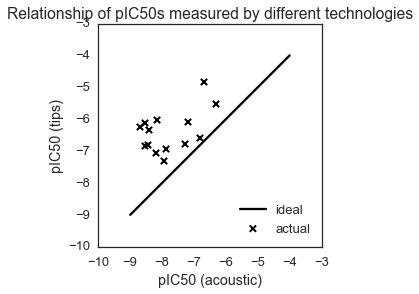

In [4]:
# Plot this data to show the relationship of pIC50's measured by different technologies
plt.subplot(111, aspect='equal');
plt.plot([-9, -4], [-9, -4], 'k-');
plt.scatter(echo_pIC50s, genesis_pIC50s,color='k',marker='x',s=40, linewidth=2);
plt.xlabel('pIC50 (acoustic)');
plt.ylabel('pIC50 (tips)');
plt.legend(['ideal', 'actual'], loc='lower right');
plt.title('Relationship of pIC50s measured by different technologies');

###1. Calculating $IC_{50}$ for EphB4 system from assay data.

This data is for $IC_{50}$s of ligands with the enzyme EphB4. From the [EphB4 DataSheet](http://www.proqinase.com/kinase-database/pdfs/2843.pdf), we know the Km for ATP by EphB4 is 1.71 uM . Note that we're assuming that EphB4 obeys Michaelis-Menten kinetics here, and that V0/Vmax is what is measured.

In [5]:
Km = 1.71e-6 # Km of ATP for EphB4 (M)

Let's assume true Ki for an arbitrary compound is 10 nM, a substrate concentration of 4 µM ATP, and that we're using 0.25 ng of ~42.4 kDa enzyme, which gives us 6 µM. We will dispense 2 µL of diluted compound into an assay plate well into which 10 µL of enzyme mix has been dispense.

In [6]:
true_Ki = 10e-9 # arbitrary compound Ki (M)

substrate_concentration = 4e-6 # ATP concentration (M)

enzyme_concentration = 6e-6 # EphB4 assay concentration (M)

Let's suppose the 10 µL of assay mix in each well was dispensed completely accurately, and contains exact concentrations of enzyme and substrate. We presume inhibition is measured by an exact read of the reaction V0/Vmax.  The IC50 would be the interpolated point at which V0/Vmax drops to 0.5, as determined from a fit of the competitive inhibition equations to the observed V0/Vmax for the dilution series, using the ideal dilution series concentrations in the fit.

We can calculate enzyme activities (V0/Vmax) directly from the values above using the following equation (derived using the assumptions of Michaelis-Menten kinetics for a competitive inhibitor):

$$\frac{V_{0}}{V_{max}} = \frac{[S]}{K_{m}(1+\frac{[I]}{K_{i}})+[S]}$$

In [7]:
#define the function 'competitive_inhibition' using this equation
def competitive_inhibition(substrate_concentration, inhibitor_concentration, enzyme_concentration, Ki, Km):
    V0_over_Vmax = substrate_concentration / (Km*(1 + inhibitor_concentration/Ki) + substrate_concentration)
    return V0_over_Vmax

We have already defined everything in this equation except our inhibitor concentration *[I]*, which is exactly the focus of the later parts of this notebook. Here we will define an ideal dilution series to create our inhibitor concentrations:

![alt text](img/dilution.png "dilution.png")

In [8]:
def dilution_series(Vinitial, Cinitial, Vtransfer, Vbuffer, ndilutions):
    # Initialize concentrations and volumes with zero vectors with Cinitial and Vinitial as first value
    concentrations = np.zeros([ndilutions], np.float64)
    volumes = np.zeros([ndilutions], np.float64)
    concentrations[0] = Cinitial
    volumes[0] = Vinitial
    
    # and Vbuffer as initial volume for all but first.
    for n in range(1,ndilutions):
        volumes[n] = Vbuffer
        
    # Create dilution series.
    for n in range(1,ndilutions):
        concentrations[n] = concentrations[n-1] * Vtransfer / (Vtransfer + Vbuffer)
        volumes[n] += Vtransfer
        volumes[n-1] -= Vtransfer
        
    # Remove Vtransfer from last.
    volumes[ndilutions-1] -= Vtransfer
    
    return [volumes, concentrations]

Now, let's use this dilution series to create an 8-point dilution series with an initial concentration of 10 mM, an initial volume of 100 µL and Vtransfer and Vbuffer = 50 µL.

In [9]:
Cinitial = 600e-6 # initial dilution concentration (M) = 600 uM, to match maximum assay concentration of Echo assay

ndilutions = 8 # number of dilutions, including initial dilution

Vinitial = 100e-6 # working volume (L)

Vtransfer = 50e-6 # volume transferred from previous dilution (L)

Vbuffer = 50e-6 # volume of diluent (buffer) added (L)

[assay_volumes, assay_compound_concentrations] = dilution_series(Vinitial, Cinitial, Vtransfer, Vbuffer, ndilutions)

In [10]:
print "Now we have an %s-point dilution series from %f uM to %f uM." % (ndilutions, assay_compound_concentrations.max()/1e-6, assay_compound_concentrations.min()/1e-6)

Now we have an 8-point dilution series from 600.000000 uM to 4.687500 uM.


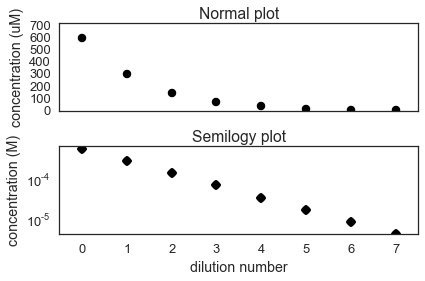

In [11]:
f, (ax1,ax2) = plt.subplots(2,1,sharex=True)

ax1.scatter(range(ndilutions), assay_compound_concentrations/1e-6, lw=4)

ax1.set_title("Normal plot")
ax1.set_ylabel('concentration (uM)')
ax1.axis([- 0.5, ndilutions - 0.5, 0.0, Cinitial * 1.2/1e-6])

ax2.semilogy(range(ndilutions), assay_compound_concentrations,'ko')

ax2.set_title("Semilogy plot")
ax2.set_ylabel('concentration (M)')
ax2.axis([- 0.5, ndilutions - 0.5, 0.0, Cinitial * 1.2])

plt.xlabel('dilution number')
f.tight_layout()

Now we can use these ideal assay_compound_concentrations to calculate what our activity would be for each inhibitor concentration:

In [12]:
#initialize the activity values with a zero vector
activity = np.zeros([ndilutions], np.float64)

#calclulate activity with our competitive inhibition model and our ideal assay_compound_concentrations
for i in range(ndilutions):
    activity[i] = competitive_inhibition(substrate_concentration, assay_compound_concentrations[i], enzyme_concentration, true_Ki, Km)

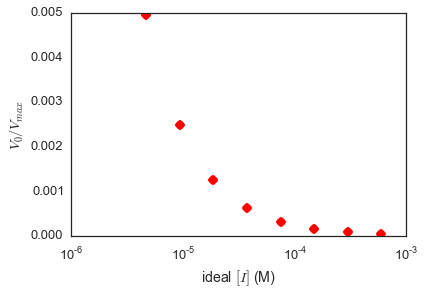

In [13]:
plt.semilogx(assay_compound_concentrations, activity, 'ro');
plt.xlabel('ideal $[I]$ (M)');
plt.ylabel('$V_{0}/V_{max}$');

Of course this is data without error bars, and is not how a real experiment would work. If we assumed both the Genesis (tip-based) and Echo (direct dispensing) methods gave us exactly the right answer for the activity, then these activity values would give us the $pIC_{50}$ values on the 'ideal' line in the first graph.

###2. Adding the inaccuracy and imprecision of the Tecan Genesis liquid-handling robot.

In reality, every experimental operation---such as a volume transfer---will be imperfect, leading to imperfect assay results.  We can model this---and its often surprising impact on the assay results---by making a simple model for the random and systematic variation with each operation.

Liquid-handling robots can't transfer the specified volume exactly. Each transfer operation has some (a) inaccuracy (modeled as a constant bias factor for all dispensing operations) and (b) imprecision (random error associated with each volume transfer). It is important to consider these factors separately, as often liquid handlers are calibrated for precision, rather than accuracy, which means bias can creep in. We'll ignore other contributions to error, such as compound stickiness, insolubility, etc., though in future iterations including them may be useful.

![https://en.wikipedia.org/wiki/Accuracy_and_precision](img/accuracy_precision_simple.png "https://en.wikipedia.org/wiki/Accuracy_and_precision")

Suppose we generate this dilution series using a Tecan Genesis robot used in the assay.

Published manufacturer specifications for the imprecision of the Tecan Genesis are available online:

[imprecision data for Tecan Genesis](http://www.frankshospitalworkshop.com/equipment/documents/automated_analyzer/user_manuals/Tecan%20Genesis%20RMP%20-%20User%20manual.pdf)

![alt text](img/GenesisImprecision.png "GenesisImprecision.png")

Tecan does not generally publish inaccuracy specifications, however, since a well-calibrated instrument can essentially eliminate inaccuracy with custom corrections applied to different volume ranges.  In order to illustrate the role inaccuracy can play, we will instead employ inaccuracy data published for a similar class of liquid handling instrument---the Beckman NX/FX span-8:

[inaccuracy/imprecision data for Biomek NX/FX](https://www.beckmancoulter.com/wsrportal/bibliography?docname=BR-10150B.pdf)

First, we define a pipetting error function for the Tecan Genesis:

In [14]:
def tecan_genesis_pipetting_model(volume):
    # Imprecision from Tecan Genesis manual.
    # Inaccuracy estimated from Beckman Biomek NX/FX span-8.
    
    imprecision_function = interp1d(
        [1.5e-6,100e-6], # volume range (L)
        [0.03, 0.005]) # published relative imprecision for corresponding volumes Tecan Genesis
    inaccuracy_function = interp1d(
        [0.5e-6, 1e-6, 100e-6], # volume range (L)
        [0.05, 0.03, 0.03]) # published relative inaccuracies for corresponding volumesfor Beckman NX/FX span-8
    
    return [inaccuracy_function(volume), imprecision_function(volume)]    

Just for reference, this is what the ideal pipetting model looks like in comparison:

In [15]:
def ideal_pipetting_model(volume):

    imprecision_function = interp1d(
        [1.5e-6, 100e-6], # volume range (L)
        [0.0, 0.0]) # relative imprecision for corresponding volumes
    inaccuracy_function = interp1d(
        [0.5e-6, 1e-6, 100e-6], # volume range (L)
        [0.0, 0.0, 0.0]) # relative inaccuracies for corresponding volumes
    
    return [inaccuracy_function(volume), imprecision_function(volume)]

Now consider a single *realization* of the automated pipetting process to generate a dilution series, utilizing the robot pipetting imprecision and inaccuracy model we defined above.

The main difference between our ideal *dilution_series* function here are that we are adding the inaccuracy in the form of the *transfer_bias*, which is a normal distribution around our inaccuracy value, to the *Vbuffer* and *Vtransfer* values. We are also then distributing this value according to a normal distribution around our imprecision value for both the *Vbuffer* and *Vtransfer* values.

In [16]:
def ROBOT_dilution_series(Vinitial, Cinitial, Vtransfer, Vbuffer, ndilutions, pipetting_model, Cstock=10e-3):    

    # Use pipetting error function to determine inaccuracy and imprecision for transferred volumes.
    [transfer_inaccuracy, transfer_imprecision] = pipetting_model(Vtransfer)    
    [buffer_inaccuracy, buffer_imprecision] = pipetting_model(Vbuffer)    

    # Draw bias for this instrument recalibration.
    # We allow the relative bias to be of different scale between the different volumes pipetted,
    # but must be same direction.
    bias = normal() # draw random normal variate that will scale inaccuracy to determine relative bias
    
    # Initialize storage for actual concentrations and volumes.
    actual_concentrations = np.zeros([ndilutions], np.float64)
    actual_volumes = np.zeros([ndilutions], np.float64)
    
    # Fill initial well of with appropriate dilution of stock solution.
    Vinitial_transfer = (Cinitial / Cstock) * Vinitial # compute transferred volume of stock solution
    Vinitial_buffer = Vinitial - Vinitial_transfer # compute transferred buffer volume
    [initial_transfer_inaccuracy, initial_transfer_imprecision] = pipetting_model(Vinitial_transfer)
    [initial_buffer_inaccuracy, initial_buffer_imprecision] = pipetting_model(Vinitial_buffer)    
    Vtransfer_actual = Vinitial_transfer * ((1+initial_transfer_inaccuracy*bias) + initial_transfer_imprecision*normal())
    Vbuffer_actual = Vinitial_buffer * ((1+initial_buffer_inaccuracy*bias) + initial_buffer_imprecision*normal())                        
    actual_volumes[0] = Vtransfer_actual + Vbuffer_actual       
    actual_concentrations[0] = Cstock * Vtransfer_actual / actual_volumes[0]
                                
    # Create dilution series.
    for n in range(1,ndilutions):
        Vtransfer_actual = Vtransfer * ((1+transfer_inaccuracy*bias) + transfer_imprecision*normal())
        Vbuffer_actual   = Vbuffer   * ((1+buffer_inaccuracy*bias)   + buffer_imprecision  *normal())
        Vtot = Vtransfer_actual + Vbuffer_actual
        actual_concentrations[n] = actual_concentrations[n-1] * Vtransfer_actual / Vtot
        actual_volumes[n]   += Vtot
        actual_volumes[n-1] -= Vtransfer_actual
    
    # Remove volume Vtransfer from last so that all wells have same intended volume.
    Vtransfer_actual = Vtransfer * ((1+transfer_inaccuracy*bias) + transfer_imprecision*normal())
    actual_volumes[ndilutions-1] -= Vtransfer_actual
    
    return [actual_volumes, actual_concentrations]

In [17]:
[actual_volumes, actual_concentrations] = \
    ROBOT_dilution_series(Vinitial, Cinitial, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)

We can visualize the deviations in concentrations generated by this imprecision and inaccuracy for this single realization.

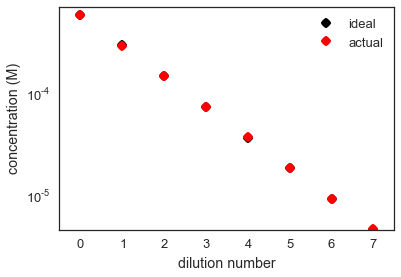

In [18]:
#Set 'ideal_concentrations' and 'ideal_volumes' to the ideal assay_compound_concentrations and assay_volumes from before.
ideal_concentrations = assay_compound_concentrations
ideal_volumes = assay_volumes

plt.semilogy(range(ndilutions), ideal_concentrations, 'ko', range(ndilutions), actual_concentrations, 'ro');
plt.xlabel('dilution number');
plt.ylabel('concentration (M)');
plt.legend(['ideal','actual']);
plt.axis([-0.5, ndilutions - 0.5, 0.0, Cinitial * 1.2]);

Note the trend that the magnitude of the concentration error increases with subsequent dilutions.  To better see this effect, we plot the relative errors in concentration, volume, and total quantity of compound per well.

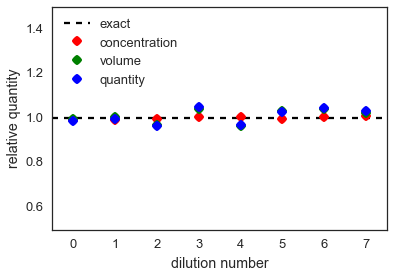

In [19]:
plt.plot([-0.5, ndilutions], [1, 1], 'k--');
plt.plot(range(ndilutions), actual_concentrations / ideal_concentrations, 'ro', \
         range(ndilutions), actual_volumes / ideal_volumes, 'go', \
         range(ndilutions), (actual_volumes*actual_concentrations)/(ideal_volumes*ideal_concentrations), 'bo');
plt.legend(['exact', 'concentration', 'volume', 'quantity'], loc='upper left');
plt.axis([-0.5, ndilutions - 0.5, 0.5, 1.5]);
plt.ylabel('relative quantity');
plt.xlabel('dilution number');

Since this was only a single *realization* of the pipetting process, it is difficult to draw conclusions about the *typical* errors in creating a dilution series with a liquid handler.  We can do this by simulating *many* independent realizations of the same experiment, and then estimate the **coefficient of variation (CV)** from the variation among experiments.

So, let's repeat the experiment 5000 times:

In [20]:
nreplicates = 5000

actual_volumes_n = np.zeros([nreplicates, ndilutions], np.float64)
actual_concentrations_n = np.zeros([nreplicates, ndilutions], np.float64)

for replicate in range(nreplicates):
    [actual_volumes_replicate, actual_concentrations_replicate] = \
        ROBOT_dilution_series(Vinitial, Cinitial, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)
        
    actual_volumes_n[replicate,:] = actual_volumes_replicate
    actual_concentrations_n[replicate,:] = actual_concentrations_replicate

Now let's use this to compute the CV, using numpy.std, which calculates the standard deviation:

In [21]:
volumes_cv = (actual_volumes_n / ideal_volumes).std(0)
concentrations_cv = (actual_concentrations_n / ideal_concentrations).std(0)
quantity_cv = ((actual_volumes_n * actual_concentrations_n) / (ideal_volumes * ideal_concentrations)).std(0)

Plotting the CV as a function of dilution number reveals surprising trends.

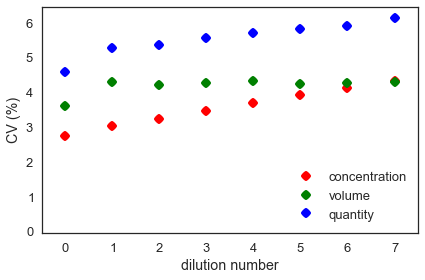

In [22]:
plt.plot(range(ndilutions), concentrations_cv*100, 'ro', \
         range(ndilutions), volumes_cv*100, 'go', \
         range(ndilutions), quantity_cv*100, 'bo')
plt.xlabel('dilution number')
plt.ylabel('CV (%)')
plt.xlim([-0.5, ndilutions - 0.5])
plt.ylim([0,6.5])
plt.legend(['concentration', 'volume', 'quantity'], loc='lower right');
plt.tight_layout();
plt.savefig('tips-quantity_CV.eps', format='eps', dpi=1000);

While the error in volume is relatively constant with dilution number, the CV (imprecision) in both concentration and quantity of compound increases with dilution number: up to 6% in the final sample.

What about bias?  Is there significant deviation from the expected average concentration due to this process?

Let's look at the mean of all these values for this 5000 replicate test.

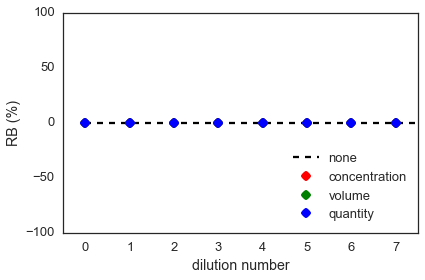

In [23]:
# Compute relative bias.
volumes_bias = (actual_volumes_n / ideal_volumes).mean(0) - 1
concentrations_bias = (actual_concentrations_n / ideal_concentrations).mean(0) - 1
quantity_bias = ((actual_volumes_n * actual_concentrations_n) / (ideal_volumes * ideal_concentrations)).mean(0) - 1

#Let's define DILUTIONS to make plotting easier.
dilutions = np.arange(ndilutions)

# Plot relative biases.
plt.plot([0, ndilutions], [0, 0], 'k--', dilutions, concentrations_bias*100, 'ro', \
     dilutions, volumes_bias*100, 'go', dilutions, quantity_bias*100, 'bo')
plt.xlabel('dilution number')
plt.ylabel('RB (%)')
plt.legend(['none','concentration', 'volume', 'quantity'], loc='lower right')
plt.axis([-0.5, ndilutions - 0.5, -100, 100]);
plt.tight_layout();
plt.savefig('tips-quantity_bias.eps', format='eps', dpi=1000);

We see that the process is essentially free of bias, which is expected if the bias for each realization of the experiment is chosen randomly for this model.  In reality, if multiple experiments are run with the same instrument without recalibration, the same bias in dispensing volumes would lead to biased assay results, but for the purposes of this simulation, we are sampling over many random recalibrations of the same instrument.

Now lets see how our estimation of enzyme activity is affected by including imprecision and inaccuracy, running many assay replicates.

First we need to add one more step of pipetting that includes our pipetting imprecision and inaccuracy as we transfer  a *compound_volume* (2 uL) of our dilution series into the enzyme assay solution of volume *mix_volume* (10 uL):

[  1.00000000e-04   5.00000000e-05   2.50000000e-05   1.25000000e-05
   6.25000000e-06   3.12500000e-06   1.56250000e-06   7.81250000e-07]


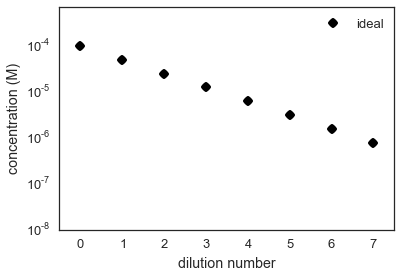

In [24]:
compound_volume = 2.0e-6 # volume of compound dilution added to assay (L)
mix_volume = 10.0e-6 # volume of enzyme assay mix added to assay (L)
ideal_assay_concentrations = ideal_concentrations * ( compound_volume/(compound_volume + mix_volume) ) # ideal (L)

# Plot the concentration range in the final assay
plt.semilogy(range(ndilutions), ideal_assay_concentrations, 'ko');
plt.xlabel('dilution number');
plt.ylabel('concentration (M)');
plt.legend(['ideal']);
plt.axis([-0.5, ndilutions - 0.5, 1e-8, Cinitial * 1.2]);
print ideal_assay_concentrations

In [25]:
def robot_dispense(compound_volume, mix_volume, compound_concentrations, pipetting_model):
    [compound_inaccuracy, compound_imprecision] = pipetting_model(compound_volume)
    [mix_inaccuracy, mix_imprecision] = pipetting_model(mix_volume)
    
    from numpy.random import normal
    dispense_volume = np.zeros([ndilutions], np.float64)
    dispense_compound_concentration = np.zeros([ndilutions], np.float64)
    
    compound_bias = compound_inaccuracy * normal()
    mix_bias = mix_inaccuracy * normal()

    for i in range(ndilutions):
        compound_volume_dispensed = compound_volume * ((1+compound_bias) + compound_imprecision*normal())
        mix_volume_dispensed = mix_volume * ((1+mix_bias) + mix_imprecision*normal())
        dispense_volume[i] = compound_volume_dispensed + mix_volume_dispensed
        dispense_compound_concentration[i] = compound_concentrations[i] * compound_volume_dispensed / dispense_volume[i]

    return [dispense_volume, dispense_compound_concentration]

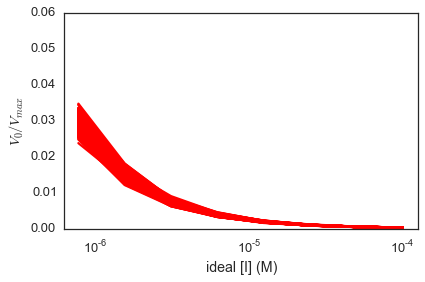

In [26]:
#initialize the activity values with a zero vector
activity = np.zeros([nreplicates,ndilutions], np.float64)

#calclulate activity with our competitive inhibition model and our new actual_concentrations for nreplicates
for replicate in range(nreplicates):
    # create a dilution series
    [actual_volumes, actual_concentrations] = ROBOT_dilution_series(Vinitial, Cinitial, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)
    # combine aliquot of compound dilution with assay mix
    [dispense_volumes, dispense_compound_concentrations] = robot_dispense(compound_volume, mix_volume, actual_concentrations, tecan_genesis_pipetting_model)
    # measure V_0/V_max for each dilution
    for i in range(ndilutions):
        activity[replicate,i] = competitive_inhibition(substrate_concentration, dispense_compound_concentrations[i], enzyme_concentration, true_Ki, Km)

#plot a subset of V_0/V_max realizations
plt.semilogx(ideal_assay_concentrations, activity[::10].transpose(), 'r-');
plt.xlabel('ideal [I] (M)');
plt.ylabel('$V_{0}/V_{max}$');
plt.axis([10**(-6.2), 10**(-3.9), 0, 0.06]);
plt.tight_layout();
plt.savefig('tips-activity.eps', format='eps', dpi=1000);

It's not hard to see that the activity will vary over a substantial range.

To determine the distribution of $IC_{50}$s consistent with the newly imposed experimental errors, we next use a nonlinear fit to each realization of the experiment to extract an $IC_{50}$ using this relationship to Ki for competitive inhibition, where we have already defined *[S]* and *Km* as constants:

$$IC_{50} = K_{i}(1+\frac{[S]}{K_{m}})$$

In [27]:
#define the function 'competitive_inhibition_IC50' using this equation
def competitive_inhibition_IC50(substrate_concentration, inhibitor_concentration, enzyme_concentration, IC50, Km):
    Ki = IC50/(1 + substrate_concentration/Km)
    return competitive_inhibition(substrate_concentration, inhibitor_concentration, enzyme_concentration, Ki, Km)

In [28]:
def fit_ic50(inhibitor_concentrations, activities, Ki_guess):
    
    def objective(inhibitor_concentrations, IC50):
        ndilutions = len(inhibitor_concentrations)
        activities = np.zeros([ndilutions], np.float64)
        for i in range(ndilutions):
            activities[i] = competitive_inhibition_IC50(substrate_concentration, inhibitor_concentrations[i], enzyme_concentration, IC50, Km)
            
        return activities - activities.min()
    
    # fit the IC50 using a good initial guess for curve_fit        
    import scipy.optimize
    IC50_guess = Ki_guess*(1 + substrate_concentration/Km)
    [popt, pcov] = scipy.optimize.curve_fit(objective, inhibitor_concentrations, activities - activities.min(), p0=[IC50_guess], maxfev=1000)
    
    return popt[0]

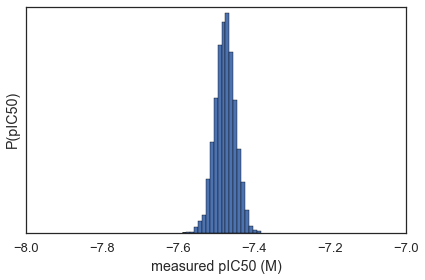

In [29]:
IC50s_tips = np.zeros([nreplicates], np.float64)
for replicate in range(nreplicates):
    IC50s_tips[replicate] = fit_ic50(ideal_assay_concentrations, activity[replicate,:], true_Ki)
pIC50s_tips = np.log10(IC50s_tips)
    
nhist = 20
plt.hist(pIC50s_tips, nhist);
plt.xlabel('measured pIC50 (M)');
plt.ylabel('P(pIC50)');
plt.yticks([]);
plt.xlim(-8, -7);
plt.tight_layout();
plt.savefig('tips-pIC50.eps', format='eps', dpi=1000);

The imprecision and inaccuracy in the measured $pIC_{50}$s may not be uniform across the whole $K_i$ range, however.  To see if there is variation as a function of true inhibitor $K_i$, we can characterize imprecision and inaccuracy as a function of $pK_i$.

In [30]:
def robot_IC50s(true_Ki):
    nreplicates = 1000
    IC50s = np.zeros([nreplicates], np.float64)
    for replicate in range(nreplicates):
        [actual_volumes, actual_concentrations] = ROBOT_dilution_series(Vinitial, Cinitial, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)
        [dispense_volumes, dispense_compound_concentrations] = robot_dispense(compound_volume, mix_volume, actual_concentrations, tecan_genesis_pipetting_model)
        activities = np.zeros([ndilutions], np.float64)
        for i in range(ndilutions):
            activities[i] = competitive_inhibition(substrate_concentration,  dispense_compound_concentrations[i], enzyme_concentration, true_Ki, Km)
        IC50s[replicate] = fit_ic50(ideal_assay_concentrations, activities, true_Ki)
    return IC50s

In [31]:
#define arbitrary pKi array
pKis = np.array([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3], np.float64);
Kis = 10**pKis
nKis = len(pKis)

#initialize with zeros
genesis_pIC50_bias = np.zeros([nKis], np.float64)
genesis_pIC50_CV = np.zeros([nKis], np.float64)

for (i, Ki) in enumerate(Kis):
    IC50s = robot_IC50s(Ki)    
    pIC50s = np.log10(IC50s)
    pIC50_true = np.log10(Kis[i]*(1 + substrate_concentration/Km))
    genesis_pIC50_bias[i] = pIC50s.mean() - pIC50_true;
    genesis_pIC50_CV[i] = pIC50s.std() / abs(pIC50s.mean())   

We can plot the bias in the measured $pIC_{50}$ values to examine the bias and CV.

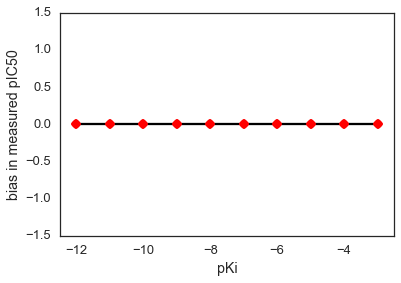

In [32]:
# Plot relative error in measured Ki values as a function of true Ki.
plt.plot([pKis.min(), pKis.max()], [0, 0], 'k-', pKis, genesis_pIC50_bias, 'ro');
plt.xlabel('pKi');
plt.ylabel('bias in measured pIC50');
plt.axis([pKis.min()-0.5, pKis.max()+0.5, -1.5,1.5]);

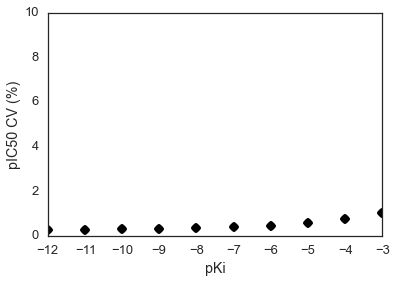

In [33]:
plt.plot(pKis, genesis_pIC50_CV*100, 'ko');
plt.xlabel('pKi');
plt.ylabel('pIC50 CV (%)');
plt.axis([pKis.min(), pKis.max(), 0, 10]);

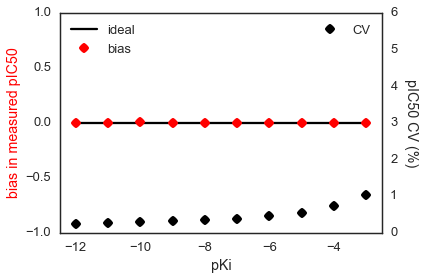

In [34]:
# Combine these plots into one!
fig,ax1 = plt.subplots()

ax1.plot([pKis.min(), pKis.max()], [0, 0], 'k-', pKis, genesis_pIC50_bias, 'ro');
ax1.set_xlabel('pKi');
ax1.set_ylabel('bias in measured pIC50', color='r');
ax1.axis([pKis.min()-0.5, pKis.max()+0.5, -1,1]);
ax1.legend(['ideal','bias'], loc='upper left')

ax2=ax1.twinx()
ax2.plot(pKis, genesis_pIC50_CV*100, 'ko');
ax2.set_ylabel('pIC50 CV (%)',rotation=270,labelpad=20);
ax2.axis([pKis.min()-.5, pKis.max()+.5, 0, 6]);
ax2.legend(['CV'], loc='upper right')

plt.tight_layout()
plt.savefig('tips-CV-bias-pIC50.eps', format='eps', dpi=1000)

###3. Compare this to inaccuracy and imprecision for acoustic dispensing with the LabCyte Echo.

Preparation of a dilution series by direct dispensing with the LabCyte Echo is a different process.  In the protocol described in [2], various quantities of 10 mM stock up to 120 uL were dispensed using the Echo, and then backfilled to 120 uL with DMSO.

According to published [inaccuracy/imprecision specifications for LabCyte Echo](http://www.labcyte.com/sites/default/files/support_docs/Echo%205XX%20Specifications.pdf), the Echo has an inaccuracy of 10% and an imprecision of 8% over the entire dispense range of 2.5 nL to 10 uL.  We consider a 8-point dilution series spanning 2.5 nL (the smallest quantity the Echo can dispense) to 120 nL (the largest quantity dispensed in the assay) from 10 mM stock solution.

![alt text](img/Echo.png "Echo.png")

Unlike for tip-based dispensing, here we aren't creating a dilution series, we will be directly dispensing the assay amounts into the assay wells. We will apply the inaccuracy and imprecision in a similar way as before, to determine the normal distribution around which to define *dispense_volumes* and *backfill_volume*. The *backfill_volume* is the volume of DMSO added to the mix in addition to the compound stock (also in DMSO) so that the concentration of DMSO remains constant throughout the assay.

![alt text](img/direct_dispense.png "direct_dispense.png")

In [35]:
# define echo_assay_dispense function that mimics the process of dispensing from the Echo into mix_volume
def echo_assay_dispense(C0, mix_volume, backfill_volume, dispense_volumes):
    # Manufacturer specifications for LabCyte Echo relative inaccuracy and imprecision
    echo_inaccuracy = 0.10
    echo_imprecision = 0.08

    ndilutions = len(dispense_volumes)
    echo_volume = np.zeros([ndilutions], np.float64)
    echo_concentration = np.zeros([ndilutions], np.float64)
    echo_bias = echo_inaccuracy * normal()
    
    for i in range(ndilutions):
        # Compute intended dispensing volumes.
        compound_volume_intended = dispense_volumes[i]
        backfill_volume_intended = backfill_volume - compound_volume_intended
        
        compound_volume_dispensed = compound_volume_intended * ((1+echo_bias) + echo_imprecision*normal())
        backfill_volume_dispensed = backfill_volume_intended * ((1+echo_bias) + echo_imprecision*normal())
        
        # Dispense the assay mix with a Tecan Genesis
        [genesis_inaccuracy, genesis_imprecision] = tecan_genesis_pipetting_model(mix_volume)
        bias = normal()
        actual_mix_volume = mix_volume * ((1+genesis_inaccuracy*bias) + genesis_imprecision*normal())

        # Compute assay volume and concentration
        echo_volume[i] = actual_mix_volume + backfill_volume_dispensed + compound_volume_dispensed
        echo_concentration[i] = C0 * compound_volume_dispensed / echo_volume[i]

    return [echo_volume, echo_concentration]

Now, let's use this *echo_assay_dispense* function to create an 8-point dilution series with DMSO compound stock concentration as 10 mM, a final assay volume of 12 µL, and an 8-point titration of dispense volumes in multiples of 15 nL. To make sure our DMSO concentration does not vary as we vary our compound concentration, we'll always backfill up to 120 nL total DMSO.

[  2.08333333e-06   4.16666667e-06   8.33333333e-06   1.66666667e-05
   3.33333333e-05   5.00000000e-05   6.66666667e-05   1.00000000e-04]


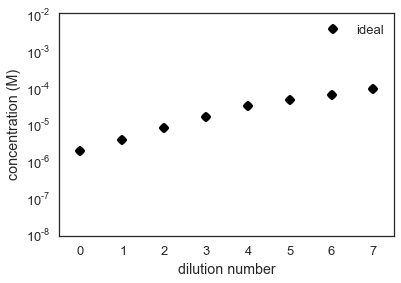

In [36]:
echo_C0 = 10e-3 # DMSO stock concentration (M)

assay_volume = 12e-6 # final assay volume (L)

echo_dispense_volumes = 2.5e-9 * np.array([1, 2, 4, 8, 16, 24, 32, 48]) # rougly logarithmic dispense volumes in multiples of 2.5 nL 

ndilutions_echo = len(echo_dispense_volumes)

backfill_volume = 120e-9 # total Echo dispense volume including compound and DMSO backfilling (L)

mix_volume = assay_volume - backfill_volume # assay mix volume to be added by liquid handler (L)

#Check our concentrations are as expected
echo_ideal_concentrations = (echo_C0*echo_dispense_volumes/assay_volume)
plt.semilogy(range(ndilutions_echo), echo_ideal_concentrations, 'ko');
plt.xlabel('dilution number');
plt.ylabel('concentration (M)');
plt.legend(['ideal']);
plt.axis([-0.5, ndilutions_echo - 0.5, 1e-8, echo_C0 * 1.2]);
print echo_ideal_concentrations

In [37]:
[echo_volumes, echo_concentrations] = echo_assay_dispense(echo_C0, mix_volume, backfill_volume, echo_dispense_volumes)

Let's plot a single realization of an Echo dispense experiment:

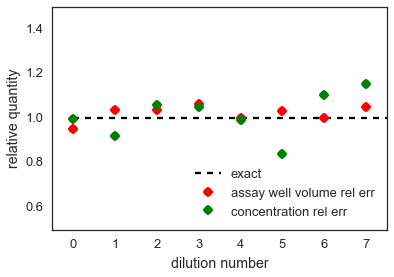

In [38]:
plt.plot([0,ndilutions_echo], [1, 1], 'k--', range(ndilutions_echo), echo_volumes / assay_volume,'ro',\
         range(ndilutions_echo), echo_concentrations / echo_ideal_concentrations, 'go');
plt.legend(['exact', 'assay well volume rel err', 'concentration rel err'], loc='lower right')
plt.axis([-0.5, ndilutions_echo - 0.5, 0.5, 1.5])
plt.ylabel('relative quantity')
plt.xlabel('dilution number');

We simulate many realizations of the same experiment to quantify imprecision and bias in the dilution series.

In [39]:
# initialize with zeros
actual_volumes_n = np.zeros([nreplicates, ndilutions_echo], np.float64)
actual_concentrations_n = np.zeros([nreplicates, ndilutions_echo], np.float64)

# initialize volume array with assay_volume value
volume_array = np.ones([ndilutions_echo]) * assay_volume

for replicate in range(nreplicates):
    [actual_volumes_replicate, actual_concentrations_replicate] = echo_assay_dispense(echo_C0, mix_volume, backfill_volume, echo_dispense_volumes)
    actual_volumes_n[replicate,:] = actual_volumes_replicate
    actual_concentrations_n[replicate,:] = actual_concentrations_replicate
volumes_cv = (actual_volumes_n / assay_volume).std(0)
concentrations_cv = (actual_concentrations_n / echo_ideal_concentrations).std(0)
quantity_cv = ((actual_volumes_n * actual_concentrations_n) / (assay_volume * echo_ideal_concentrations)).std(0)

We can now plot the CVs to examine the imprecision in the resulting compound concentrations.

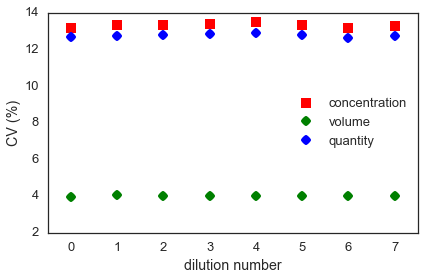

In [40]:
# define dilutions to make plotting easier.
dilutions = np.arange(ndilutions_echo)

plt.plot(dilutions, concentrations_cv*100, 'rs', dilutions, volumes_cv*100, 'go', dilutions, quantity_cv*100, 'bo')
plt.xlabel('dilution number')
plt.ylabel('CV (%)')
plt.xlim([-0.5,ndilutions_echo - 0.5])
plt.legend(['concentration', 'volume', 'quantity'], loc='center right');
plt.tight_layout();
plt.savefig('echo-quantity_CV.eps', format='eps', dpi=1000);

We again quantify the bias:

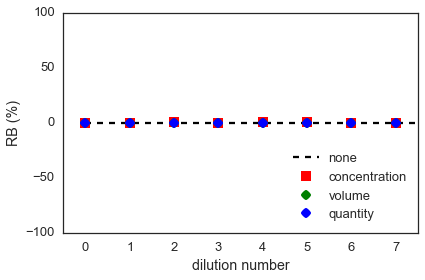

In [41]:
# Compute relative bias.
volumes_bias = (actual_volumes_n / assay_volume).mean(0) - 1
concentrations_bias = (actual_concentrations_n / echo_ideal_concentrations).mean(0) - 1
quantity_bias = ((actual_volumes_n * actual_concentrations_n) / (assay_volume * echo_ideal_concentrations)).mean(0) - 1

# Plot relative biases.
plt.plot([0, ndilutions_echo], [0, 0], 'k--', dilutions, concentrations_bias*100, 'rs', \
     dilutions, volumes_bias*100, 'go', dilutions, quantity_bias*100, 'bo')
plt.xlabel('dilution number')
plt.ylabel('RB (%)')
plt.legend(['none','concentration', 'volume', 'quantity'], loc='lower right')
plt.axis([-0.5, ndilutions_echo - 0.5, -100, 100]);
plt.tight_layout();
plt.savefig('echo-quantity_bias.eps', format='eps', dpi=1000);

Again, bias over many random calibrations of the same instrument is expected to be zero.

Now lets see how our estimation of enzyme activity is affected by including imprecision and inaccuracy, running many assay replicates.

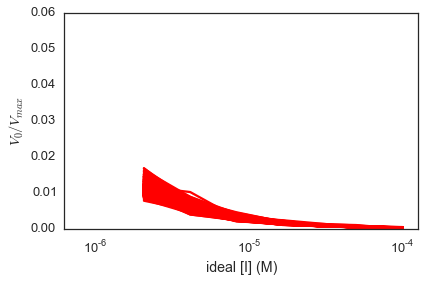

In [42]:
#initialize the activity values with a zero vector
activity = np.zeros([nreplicates,ndilutions_echo], np.float64)

#calclulate activity with our competitive inhibition model and our new actual_concentrations for nreplicates
for replicate in range(nreplicates):
    [actual_volumes, actual_concentrations] = echo_assay_dispense(echo_C0, mix_volume, backfill_volume, echo_dispense_volumes)
    for i in range(ndilutions_echo):
        activity[replicate,i] = competitive_inhibition(substrate_concentration, actual_concentrations[i], enzyme_concentration, true_Ki, Km)

#plot
plt.semilogx(echo_ideal_concentrations, activity[::10].transpose(), 'r-');
plt.xlabel('ideal [I] (M)');
plt.ylabel('$V_{0}/V_{max}$');
plt.axis([10**(-6.2), 10**(-3.9), 0, 0.06]);
plt.tight_layout();
plt.savefig('echo-activity.eps', format='eps', dpi=1000);

Let's check our $pIC_{50}$ histogram using the same `fit_ic50` function from before.

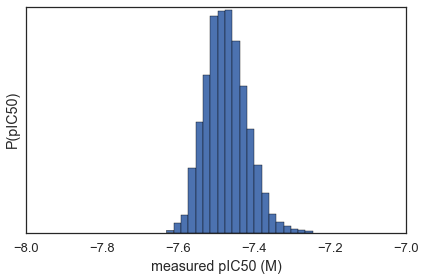

In [43]:
IC50s_echo = np.zeros([nreplicates], np.float64)
for replicate in range(nreplicates):
    IC50s_echo[replicate] = fit_ic50(echo_ideal_concentrations, activity[replicate,:], true_Ki)                        
pIC50s_echo = np.log10(IC50s_echo)
    
nhist = 20
plt.hist(pIC50s_echo, nhist);
plt.xlabel('measured pIC50 (M)');
plt.ylabel('P(pIC50)');
plt.yticks([]);
plt.xlim(-8, -7);
plt.tight_layout();
plt.savefig('echo-pIC50s.eps', format='eps', dpi=1000);

Similarly, the imprecision and inaccuracy in the measured pIC50s may not be uniform across the whole $K_i$ range, however, so we will characterize imprecision and inaccuracy as a function of $pK_i$.

In [44]:
def echo_IC50s(true_Ki):
    nreplicates = 1000
    IC50s = np.zeros([nreplicates], np.float64)
    for replicate in range(nreplicates):
        [assay_volumes, actual_concentrations] = echo_assay_dispense(echo_C0, mix_volume, backfill_volume, echo_dispense_volumes)
        activities = np.zeros([ndilutions_echo], np.float64)
        for i in range(ndilutions_echo):
            activities[i] = competitive_inhibition(substrate_concentration, actual_concentrations[i], enzyme_concentration, true_Ki, Km)
        IC50s[replicate] = fit_ic50(echo_ideal_concentrations, activities, true_Ki)
    return IC50s

In [45]:
# Initialize with zeros.
echo_pIC50_bias = np.zeros([nKis], np.float64)
echo_pIC50_CV = np.zeros([nKis], np.float64)

for (i, Ki) in enumerate(Kis):
    IC50s = echo_IC50s(Ki)    
    pIC50s = np.log10(IC50s)
    pIC50_true = np.log10(Kis[i]*(1 + substrate_concentration/Km))
    echo_pIC50_bias[i] = pIC50s.mean() - pIC50_true;
    echo_pIC50_CV[i] = pIC50s.std() / abs(pIC50s.mean())  

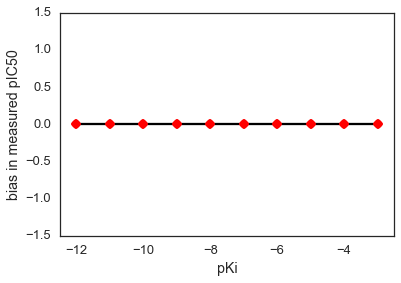

In [46]:
# Plot relative error in measured Ki values as a function of true Ki.
plt.plot([pKis.min(), pKis.max()], [0, 0], 'k-', pKis, echo_pIC50_bias, 'ro');
plt.xlabel('pKi');
plt.ylabel('bias in measured pIC50');
plt.axis([pKis.min()-0.5, pKis.max()+0.5, -1.5,1.5]);

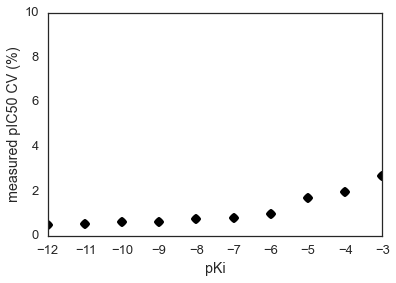

In [47]:
#Plot CV.
plt.plot(pKis, echo_pIC50_CV*100, 'ko');
plt.xlabel('pKi');
plt.ylabel('measured pIC50 CV (%)');
plt.axis([pKis.min(), pKis.max(), 0, 10]);

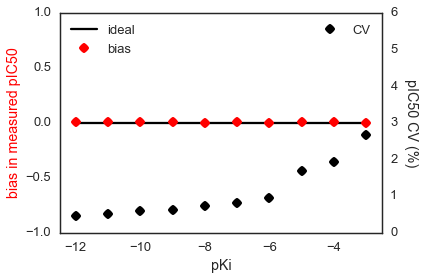

In [48]:
# Combine these plots into one!
fig,ax1 = plt.subplots()

ax1.plot([pKis.min(), pKis.max()], [0, 0], 'k-', pKis, echo_pIC50_bias, 'ro');
ax1.set_xlabel('pKi');
ax1.set_ylabel('bias in measured pIC50', color='r');
ax1.axis([pKis.min()-0.5, pKis.max()+0.5, -1,1]);
ax1.legend(['ideal','bias'], loc='upper left')

ax2=ax1.twinx()
ax2.plot(pKis, echo_pIC50_CV*100, 'ko');
ax2.set_ylabel('pIC50 CV (%)',rotation=270,labelpad=20);
ax2.axis([pKis.min()-.5, pKis.max()+.5, 0, 6]);
ax2.legend(['CV'], loc='upper right')

plt.tight_layout()
plt.savefig('echo-CV-bias-pIC50.eps', format='eps', dpi=1000)

### 4. Add to model: dilution by system liquid of the Tecan Genesis liquid-handling robot.

The Tecan Genesis supports the use of both disposable tips and fixed tips. When operating with fixed tips, syringes use a system liquid (generally water or buffer) to aspirate and dispense during liquid transfers.  While an air gap remains between the liquid being transferred and the system liquid, the system liquid is used to flush the tips into waste after transfers in order to remove any liquid residue before the next transfer. Because a small quantity of system liquid residue remains coating the tip after washing, fixed tips can actually *dilute* the sample being transferred unless special protocols are used to prevent this. A good description of this phenomonen can be found in [Dilution effect in multichannel liquid-handling system equipped with fixed tips:Problems and solutions for bioanalytical sample preparation. J. Lab. Autom. 12(6): 2007](http://dx.doi.org/10.1016/j.jala.2007.07.002), including the diagram below:

![alt text](img/dilution_effect_diagram.png "dilution_effect_diagram.png")

The magnitude of this dilution effect was noted in a 2006 paper by Dong et al at BMS, [The use of a dual dye photometric calibration method to identify possible sample dilution from an automated multichannel liquid-handling system. J. Lab. Autom. 11(2): 2006](http://dx.doi.org/10.1016/j.jala.2006.02.005), which quite surprisingly can have a large impact on dilution series preparation. The relevant table from this paper is below.

![alt text](img/DilutionError_small.png "DilutionError_small.png")

In [49]:
# Define a function to interpolate the dilution effect between the measured values of Dong et al. 2006
# (extended to 1 uL volumes)
volume = np.array([1, 20, 200]) * 1e-6 # volumes at which dilution effect was quantified (L)
dilution_effect = np.array([-0.0630, -0.0630, -0.0496]) # relative inaccuracy due to dilution with system liquid at corresponding volumes

dilution_function = interp1d(volume, dilution_effect) # interpolation function

We introduce a modified model of our dilution series that now incorporates this dilution effect.

Note that the only difference between this function and our `ROBOT_dilution_series` function is that `actual_concentrations[n]` value now includes our `dilution_function` term.

In [50]:
def DILUTE_ROBOT_dilution_series(Vinitial, Cinitial, Vtransfer, Vbuffer, ndilutions, pipetting_model, Cstock=10e-3):

    # Use pipetting error function to determine inaccuracy and imprecision for transferred volumes.
    [transfer_inaccuracy, transfer_imprecision] = pipetting_model(Vtransfer)    
    [buffer_inaccuracy, buffer_imprecision] = pipetting_model(Vbuffer)    

    # Draw bias for this instrument recalibration.
    # We allow the relative bias to be of different scale between the different volumes pipetted,
    # but must be same direction.
    bias = normal() # draw random normal variate that will scale inaccuracy to determine relative bias
    
    # Initialize storage for actual concentrations and volumes.
    actual_concentrations = np.zeros([ndilutions], np.float64)
    actual_volumes = np.zeros([ndilutions], np.float64)
    
    # Fill initial well of with appropriate dilution of stock solution.
    Vinitial_transfer = (Cinitial / Cstock) * Vinitial # compute transferred volume of stock solution
    Vinitial_buffer = Vinitial - Vinitial_transfer # compute transferred buffer volume
    [initial_transfer_inaccuracy, initial_transfer_imprecision] = pipetting_model(Vinitial_transfer)
    [initial_buffer_inaccuracy, initial_buffer_imprecision] = pipetting_model(Vinitial_buffer)    
    Vtransfer_actual = Vinitial_transfer * ((1+initial_transfer_inaccuracy*bias) + initial_transfer_imprecision*normal())
    Vbuffer_actual = Vinitial_buffer * ((1+initial_buffer_inaccuracy*bias) + initial_buffer_imprecision*normal())                        
    actual_volumes[0] = Vtransfer_actual + Vbuffer_actual       
    actual_concentrations[0] = (1+dilution_function(Vtransfer_actual)) * Cstock * Vtransfer_actual / actual_volumes[0]
                                
    # Create dilution series.
    for n in range(1,ndilutions):
        Vtransfer_actual = Vtransfer * ((1+transfer_inaccuracy*bias) + transfer_imprecision*normal())
        Vbuffer_actual   = Vbuffer   * ((1+buffer_inaccuracy*bias)   + buffer_imprecision  *normal())
        Vtot = Vtransfer_actual + Vbuffer_actual
        actual_concentrations[n] = \
            (1+dilution_function(Vtransfer)) * actual_concentrations[n-1] * Vtransfer_actual / Vtot
        actual_volumes[n]   += Vtot
        actual_volumes[n-1] -= Vtransfer_actual
    
    # Remove volume Vtransfer from last so that all wells have same intended volume.
    Vtransfer_actual = Vtransfer * ((1+transfer_inaccuracy*bias) + transfer_imprecision*normal())
    actual_volumes[ndilutions-1] -= Vtransfer_actual

    return [actual_volumes, actual_concentrations]

Once again, we simulate many replicates of the same experiment, this time including the dilution effect.

In [51]:
#initialize with zeros
actual_volumes_n = np.zeros([nreplicates, ndilutions], np.float64)
actual_concentrations_n = np.zeros([nreplicates, ndilutions], np.float64)

for replicate in range(nreplicates):
    [actual_volumes_replicate, actual_concentrations_replicate] = DILUTE_ROBOT_dilution_series(Vinitial, Cinitial, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)
    actual_volumes_n[replicate,:] = actual_volumes_replicate
    actual_concentrations_n[replicate,:] = actual_concentrations_replicate

We can quantify the impact on imprecision by visualizing the CVs as a function of dilution number.

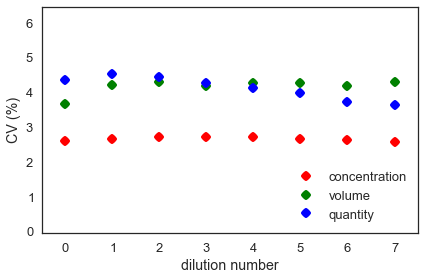

In [52]:
volumes_cv = (actual_volumes_n / ideal_volumes).std(0)
concentrations_cv = (actual_concentrations_n / ideal_concentrations).std(0)
quantity_cv = ((actual_volumes_n * actual_concentrations_n) / (ideal_volumes * ideal_concentrations)).std(0)

# Plot CVs
dilutions = np.arange(ndilutions)
plt.plot(dilutions, concentrations_cv*100, 'ro', dilutions, volumes_cv*100, 'go', dilutions, quantity_cv*100, 'bo')
plt.xlabel('dilution number')
plt.ylabel('CV (%)')
plt.xlim([-0.5, ndilutions -0.5])
plt.ylim([0,6.5])
plt.legend(['concentration', 'volume', 'quantity'], loc='lower right');plt.tight_layout();
plt.savefig('dilute-quantity_CV.eps', format='eps', dpi=1000);

We also examine the bias.

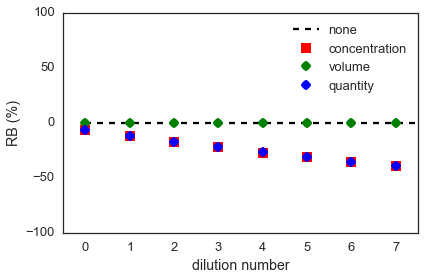

In [53]:
# Compute relative bias.
volumes_bias = (actual_volumes_n / ideal_volumes).mean(0) - 1
concentrations_bias = (actual_concentrations_n / ideal_concentrations).mean(0) - 1
quantity_bias = ((actual_volumes_n * actual_concentrations_n) / (ideal_volumes * ideal_concentrations)).mean(0)- 1

# Plot relative biases.
plt.plot([0, ndilutions], [0, 0], 'k--', dilutions, concentrations_bias*100, 'rs',\
     dilutions, volumes_bias*100, 'go', dilutions, quantity_bias*100, 'bo');
plt.xlabel('dilution number');
plt.ylabel('RB (%)');
plt.legend(['none', 'concentration', 'volume', 'quantity'], loc='upper right');
plt.axis([-0.5, ndilutions - 0.5, -100, 100]);
plt.tight_layout();
plt.savefig('dilute-quantity_bias.eps', format='eps', dpi=1000);

We now see that over many realizations with random calibrations, significant bias in both the concentration and quantity of compound accumulates with dilution number.

In [54]:
def dilute_robot_dispense(compound_volume, mix_volume, compound_concentrations, pipetting_model):
    [compound_inaccuracy, compound_imprecision] = pipetting_model(compound_volume)
    [mix_inaccuracy, mix_imprecision] = pipetting_model(mix_volume)
    
    from numpy.random import normal
    dispense_volume = np.zeros([ndilutions], np.float64)
    dispense_compound_concentration = np.zeros([ndilutions], np.float64)
    
    compound_bias = compound_inaccuracy * normal()
    mix_bias = mix_inaccuracy * normal()

    for i in range(ndilutions):
        compound_volume_dispensed = compound_volume * ((1+compound_bias) + compound_imprecision*normal())
        mix_volume_dispensed = mix_volume * ((1+mix_bias) + mix_imprecision*normal())
        dispense_volume[i] = compound_volume_dispensed + mix_volume_dispensed
        d = dilution_function(compound_volume_dispensed)
        dispense_compound_concentration[i] = (1+d) * compound_concentrations[i] \
            * compound_volume_dispensed / dispense_volume[i]

    return [dispense_volume, dispense_compound_concentration]

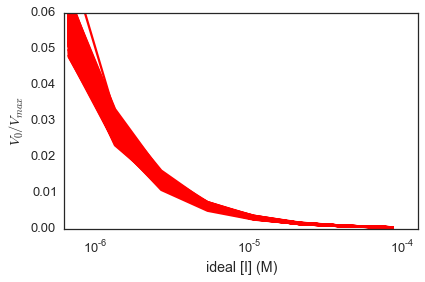

In [55]:
#initialize the activity values with a zero vector
activity = np.zeros([nreplicates,ndilutions], np.float64)
ideal_assay_concentrations = ideal_concentrations * ( compound_volume/(compound_volume + mix_volume) ) # ideal (L)

#calclulate activity with our competitive inhibition model and our new actual_concentrations for nreplicates
for replicate in range(nreplicates):
    [actual_volumes, actual_concentrations] = DILUTE_ROBOT_dilution_series(Vinitial, Cinitial, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)
    [dispense_volumes, dispense_compound_concentrations] = dilute_robot_dispense(compound_volume, mix_volume, actual_concentrations, tecan_genesis_pipetting_model)
    for i in range(ndilutions):
        activity[replicate,i] = competitive_inhibition(substrate_concentration, dispense_compound_concentrations[i], enzyme_concentration, true_Ki, Km)

#plot
plt.semilogx(ideal_assay_concentrations, activity[::10].transpose(), 'r-');
plt.xlabel('ideal [I] (M)');
plt.ylabel('$V_{0}/V_{max}$');
plt.axis([10**(-6.2), 10**(-3.9), 0, 0.06]);
plt.tight_layout();
plt.savefig('dilute-activity.eps', format='eps', dpi=1000);

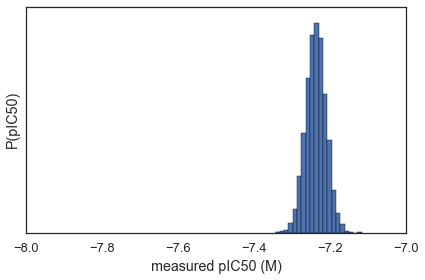

In [56]:
IC50s_tips_dilute = np.zeros([nreplicates], np.float64)
for replicate in range(nreplicates):
    IC50s_tips_dilute[replicate] = fit_ic50(ideal_assay_concentrations, activity[replicate,:], true_Ki)
pIC50s_tips_dilute = np.log10(IC50s_tips_dilute)
    
nhist = 20
plt.hist(pIC50s_tips_dilute, nhist);
plt.xlabel('measured pIC50 (M)');
plt.ylabel('P(pIC50)');
plt.yticks([]);
plt.xlim(-8, -7);
plt.tight_layout();
plt.savefig('dilute-pIC50s.eps', format='eps', dpi=1000);

In [57]:
def dilute_robot_IC50s(true_Ki):
    nreplicates = 1000
    IC50s = np.zeros([nreplicates], np.float64)
    for replicate in range(nreplicates):
        [actual_volumes, actual_concentrations] = DILUTE_ROBOT_dilution_series(Vinitial, Cinitial, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)
        [dispense_volumes, dispense_compound_concentrations] = dilute_robot_dispense(compound_volume, mix_volume, actual_concentrations, tecan_genesis_pipetting_model)
        activities = np.zeros([ndilutions], np.float64)
        for i in range(ndilutions):
            activities[i] = competitive_inhibition(substrate_concentration, dispense_compound_concentrations[i], enzyme_concentration, true_Ki, Km)
        IC50s[replicate] = fit_ic50(ideal_assay_concentrations, activities, true_Ki)
    return IC50s

print actual_concentrations

[  5.71074861e-04   2.69368805e-04   1.26329829e-04   5.95957651e-05
   2.73131252e-05   1.29783968e-05   6.09716604e-06   2.82435472e-06]


In [58]:
print ideal_concentrations * ( compound_volume/(compound_volume + mix_volume) )

[  8.64553314e-05   4.32276657e-05   2.16138329e-05   1.08069164e-05
   5.40345821e-06   2.70172911e-06   1.35086455e-06   6.75432277e-07]


In [59]:
print ideal_concentrations

[  6.00000000e-04   3.00000000e-04   1.50000000e-04   7.50000000e-05
   3.75000000e-05   1.87500000e-05   9.37500000e-06   4.68750000e-06]


In [60]:
#initialize with zeros
dilute_genesis_pIC50_bias = np.zeros([nKis], np.float64)
dilute_genesis_pIC50_CV = np.zeros([nKis], np.float64)

for (i, Ki) in enumerate(Kis):
    IC50s = dilute_robot_IC50s(Ki)    
    pIC50s = np.log10(IC50s)
    pIC50_true = np.log10(Kis[i]*(1 + substrate_concentration/Km))
    dilute_genesis_pIC50_bias[i] = pIC50s.mean() - pIC50_true;
    dilute_genesis_pIC50_CV[i] = pIC50s.std() / abs(pIC50s.mean())   

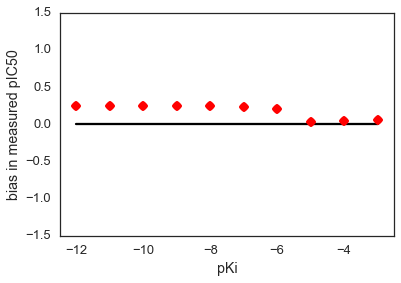

In [61]:
# Plot relative error in measured Ki values as a function of true Ki.
plt.plot([pKis.min(), pKis.max()], [0, 0], 'k-', pKis, dilute_genesis_pIC50_bias, 'ro');
plt.xlabel('pKi');
plt.ylabel('bias in measured pIC50');
plt.axis([pKis.min()-0.5, pKis.max()+0.5, -1.5,1.5]);

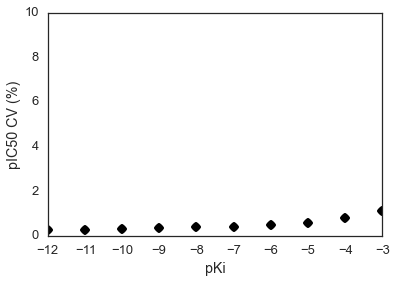

In [62]:
plt.plot(pKis, dilute_genesis_pIC50_CV*100, 'ko');
plt.xlabel('pKi');
plt.ylabel('pIC50 CV (%)');
plt.axis([pKis.min(), pKis.max(), 0, 10]);

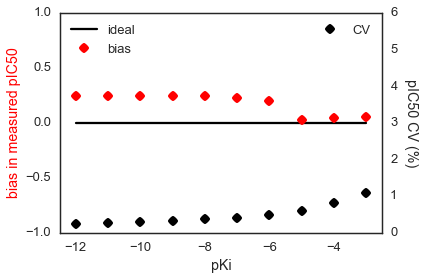

In [63]:
# Combine these plots into one!
fig,ax1 = plt.subplots()

ax1.plot([pKis.min(), pKis.max()], [0, 0], 'k-', pKis, dilute_genesis_pIC50_bias, 'ro');
ax1.set_xlabel('pKi');
ax1.set_ylabel('bias in measured pIC50', color='r');
ax1.axis([pKis.min()-0.5, pKis.max()+0.5, -1,1]);
ax1.legend(['ideal','bias'], loc='upper left')

ax2=ax1.twinx()
ax2.plot(pKis, dilute_genesis_pIC50_CV*100, 'ko');
ax2.set_ylabel('pIC50 CV (%)',rotation=270,labelpad=20);
ax2.axis([pKis.min()-.5, pKis.max()+.5, 0, 6]);
ax2.legend(['CV'], loc='upper right')

plt.tight_layout()
plt.savefig('dilute-CV-bias-pIC50.eps', format='eps', dpi=1000)


####Let's compare biases for ndilutions = 8, 16, 32

In [64]:
# Load in saved data
dilute_bias_16 = np.load('dilute_genesis_pIC50_bias_16.npy')
dilute_bias_32 = np.load('dilute_genesis_pIC50_bias_32.npy')

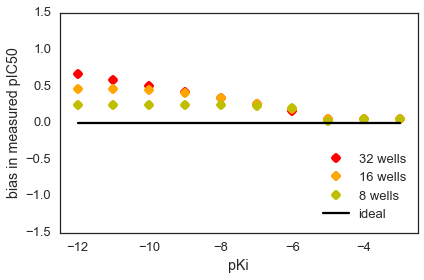

In [65]:
# Plot relative error in measured Ki values as a function of true Ki.
plt.plot(pKis, dilute_bias_32, 'ro');
plt.plot(pKis, dilute_bias_16, color='orange', marker='o',linestyle='none');
plt.plot(pKis, dilute_genesis_pIC50_bias, 'yo',[pKis.min(), pKis.max()], [0, 0], 'k-');
plt.xlabel('pKi');
plt.ylabel('bias in measured pIC50');
plt.axis([pKis.min()-0.5, pKis.max()+0.5, -1.5,1.5]);
plt.legend(['32 wells','16 wells','8 wells','ideal'], loc='lower right')
plt.tight_layout()
plt.savefig('dilute-bias-pIC50-8-16-32.eps', format='eps', dpi=1000)

### 5. Now compare Tecan Genesis and LabCyte Echo errors.

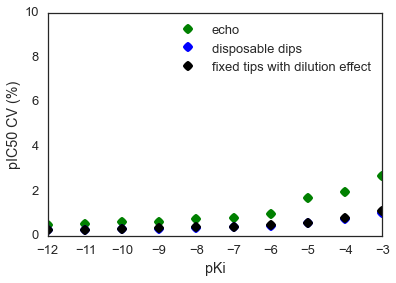

In [66]:
plt.plot(pKis, echo_pIC50_CV*100, 'go');
plt.plot(pKis, genesis_pIC50_CV*100, 'bo');
plt.plot(pKis, dilute_genesis_pIC50_CV*100, 'ko');
plt.xlabel('pKi');
plt.ylabel('pIC50 CV (%)');
plt.legend(['echo','disposable dips','fixed tips with dilution effect'])
plt.axis([pKis.min(), pKis.max(), 0, 10]);

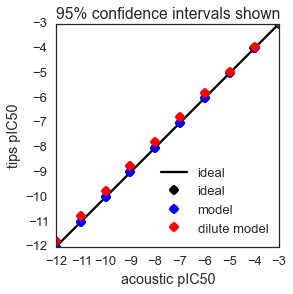

In [67]:
echo_pIC50_err = (echo_pIC50_CV*np.abs(pKis))
genesis_pIC50_err = (genesis_pIC50_CV*np.abs(pKis))
dilute_genesis_pIC50_err = (dilute_genesis_pIC50_CV*np.abs(pKis))

clf();
subplot(111, aspect='equal');
hold(True);
plot([pKis.min(), pKis.max()], [pKis.min(), pKis.max()], 'k-');
plot(pKis, pKis, 'ko');
errorbar(pKis + echo_pIC50_bias, pKis + genesis_pIC50_bias, xerr=2*echo_pIC50_err, yerr=2*genesis_pIC50_err, fmt='bo');
errorbar(pKis + echo_pIC50_bias, pKis + dilute_genesis_pIC50_bias, xerr=2*echo_pIC50_err, yerr=2*dilute_genesis_pIC50_err, fmt='ro');
axis([pKis.min(), pKis.max(), pKis.min(), pKis.max()]);
xlabel('acoustic pIC50');
ylabel('tips pIC50');
title('95% confidence intervals shown');
plt.legend(['ideal', 'ideal', 'model', 'dilute model'], loc='lower right');

In [68]:
figsize(10,10)

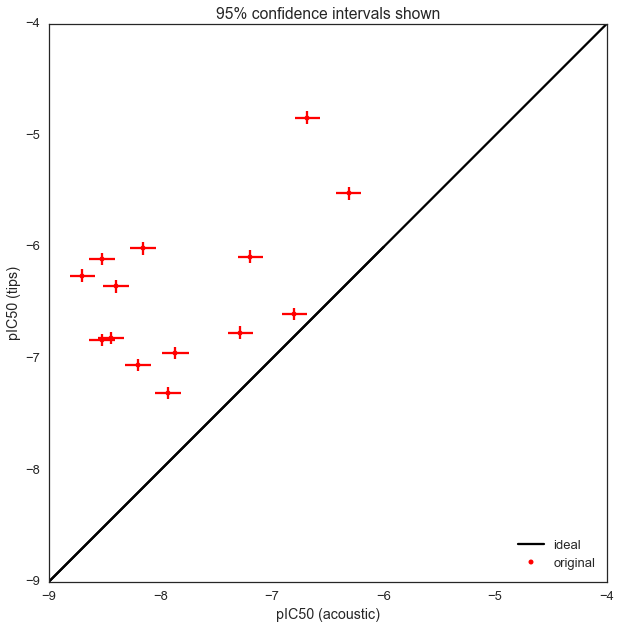

In [69]:
# Interpolate bias and CV for Echo and Genesis.
echo_bias_interpolation = interp1d(pKis, echo_pIC50_bias);
echo_CV_interpolation = interp1d(pKis, echo_pIC50_CV);
genesis_bias_interpolation = interp1d(pKis, genesis_pIC50_bias);
genesis_CV_interpolation = interp1d(pKis, genesis_pIC50_CV);
dilute_genesis_bias_interpolation = interp1d(pKis, dilute_genesis_pIC50_bias);
dilute_genesis_CV_interpolation = interp1d(pKis, dilute_genesis_pIC50_CV);

# Compute error bars for Echo and Genesis.
echo_pIC50_err = (echo_CV_interpolation(echo_pIC50s)*np.abs(echo_pIC50s))
genesis_pIC50_err = (genesis_CV_interpolation(genesis_pIC50s)*np.abs(genesis_pIC50s))
dilute_genesis_pIC50_err = (dilute_genesis_CV_interpolation(genesis_pIC50s)*np.abs(genesis_pIC50s))

# Plot with error bars.
figure();
subplot(111, aspect='equal');
hold(True);
plot([-9, -4], [-9, -4], 'k-');
errorbar(echo_pIC50s, genesis_pIC50s, xerr=2*echo_pIC50_err, yerr=2*dilute_genesis_pIC50_err, fmt='ro', markersize=5, zorder=5);
plot([-9, -6], [-9, -6], 'k-');
xlabel('pIC50 (acoustic)');
ylabel('pIC50 (tips)');
legend(['ideal', 'original'], loc='lower right');
title('95% confidence intervals shown');

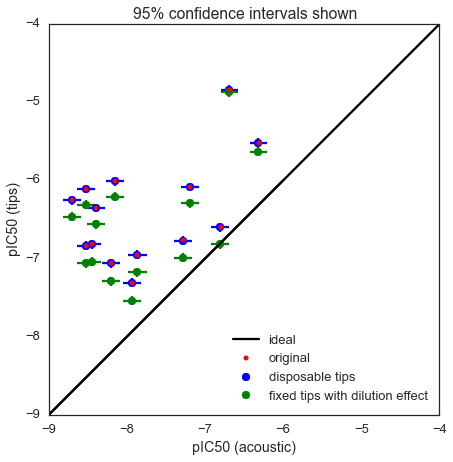

In [70]:
figsize(7,7)
# Plot.
figure();
subplot(111, aspect='equal');
hold(True);
plot([-9, -4], [-9, -4], 'k-');
#errorbar(echo_pIC50s, genesis_pIC50s, xerr=2*echo_pIC50_err, yerr=2*genesis_pIC50_err, fmt='o');
errorbar(echo_pIC50s, genesis_pIC50s, fmt='ro', markersize=5, zorder=5);
errorbar(echo_pIC50s - echo_bias_interpolation(echo_pIC50s), genesis_pIC50s - genesis_bias_interpolation(genesis_pIC50s), xerr=2*echo_pIC50_err, yerr=2*genesis_pIC50_err, markersize=8, fmt='bo');
errorbar(echo_pIC50s - echo_bias_interpolation(echo_pIC50s), genesis_pIC50s - dilute_genesis_bias_interpolation(genesis_pIC50s), xerr=2*echo_pIC50_err, yerr=2*dilute_genesis_pIC50_err, markersize=8, fmt='go');
plot([-9, -6], [-9, -6], 'k-');
xlabel('pIC50 (acoustic)');
ylabel('pIC50 (tips)');
legend(['ideal', 'original', 'disposable tips','fixed tips with dilution effect'], loc='lower right');
title('95% confidence intervals shown');
plt.savefig('compare-pIC50-bias_corrected.eps', format='eps', dpi=1000)

In [71]:
def rmse(tips,acoustic):
    return np.sqrt(((tips - acoustic) ** 2).mean())

rootmeansquareerror = rmse(genesis_pIC50s,echo_pIC50s)
print rootmeansquareerror

1.56162824385


In [72]:
rootmeansquareerror_withbias = rmse(genesis_pIC50s - genesis_bias_interpolation(genesis_pIC50s),echo_pIC50s - echo_bias_interpolation(echo_pIC50s))
print rootmeansquareerror_withbias

1.56346211557


In [73]:
rootmeansquareerror_withbias_withdilution = rmse(genesis_pIC50s - dilute_genesis_bias_interpolation(genesis_pIC50s),echo_pIC50s - echo_bias_interpolation(echo_pIC50s))
print rootmeansquareerror_withbias_withdilution

1.39640499983


### 7. Adding some sliders just for fun.

In [74]:
clf;
print genesis_bias_interpolation(genesis_pIC50s)

[  1.93325827e-04   1.50532039e-06   1.11121914e-03   4.01356984e-04
   1.00181674e-04   2.19397648e-04   5.17175516e-04   1.03009649e-03
   1.25252927e-03  -1.62902500e-04   8.24527184e-04   5.07746965e-04
   1.15574546e-03   1.08975199e-03]


In [75]:
average_genesis_bias = np.mean(dilute_genesis_bias_interpolation(genesis_pIC50s))
print average_genesis_bias

0.196847667449


In [76]:
print echo_bias_interpolation(echo_pIC50s)


[ 0.00440909  0.00312486  0.00227074  0.00254282  0.00170217  0.00227074
  0.00207769  0.00407953  0.00195319  0.00420051  0.00454094  0.00170386
  0.00176968  0.00215213]


In [77]:
average_echo_bias = np.mean(echo_bias_interpolation(echo_pIC50s))
print average_echo_bias

0.00277128148795


Now we're going to have a bit of fun. Notice how the main contribution of error is the bias in the dilute_genesis. The average of this is representative for most of the data points, so lets make this into a slider and watch how the biases change our data in real time!

Note that this uses ipywidgets, which needs to be downloaded. A tutorial can be found [here](https://jakevdp.github.io/blog/2013/12/05/static-interactive-widgets/).

In [78]:
import matplotlib.pyplot as mpld3
from matplotlib.widgets import Slider, Button, RadioButtons
from ipywidgets import StaticInteract, RangeWidget, RadioWidget

ImportError: cannot import name StaticInteract

In [ ]:
def slider_plot(error, color):
    fig, ax = sns.plt.subplots(figsize=(5, 5),
                           subplot_kw={'axisbelow':True})
    #ax.grid(color='w', linewidth=2, linestyle='solid')
    ax.plot([-9, -4], [-9, -4], 'k-');
    ax.scatter(echo_pIC50s, genesis_pIC50s - error, color=color,marker='x',s=40, linewidth=2)
    ax.set_xlabel('pIC50 (acoustic)');
    ax.set_ylabel('pIC50 (tips)');
    ax.legend(['ideal', 'actual'], loc='lower right');
    ax.set_title('Relationship of pIC50s measured by different technologies');
    return fig

StaticInteract(slider_plot,
               error=RangeWidget(0.01, average_genesis_bias, 0.01),
               color=RadioWidget(['blue']))

Now, we'll also make the same slider for the average_echo_bias, but it isn't quite as fun.

In [ ]:
def slider_plot(error, color):
    fig, ax = sns.plt.subplots(figsize=(5, 5),
                           subplot_kw={'axisbelow':True})
    #ax.grid(color='w', linewidth=2, linestyle='solid')
    ax.plot([-9, -4], [-9, -4], 'k-');
    ax.scatter(echo_pIC50s - error, genesis_pIC50s, color=color,marker='x',s=40, linewidth=2)
    ax.set_xlabel('pIC50 (acoustic)');
    ax.set_ylabel('pIC50 (tips)');
    ax.legend(['ideal', 'actual'], loc='lower right');
    ax.set_title('Relationship of pIC50s measured by different technologies');
    return fig

clf;
StaticInteract(slider_plot,
               error=RangeWidget(0.001, average_echo_bias, 0.001),
               color=RadioWidget(['green']))

Now let's try this using IPython.html.widgets: No installing or downloading anything as long as your ipython notebook is working.

In [ ]:
from IPython.html import widgets
from IPython.display import display

In [ ]:
fig, ax = plt.subplots()
plt.figure(figsize=(12,12),facecolor='red')
ax.plot([-8, -5], [-8, -5], 'k-');
plt.close(fig)

def set_cursor(a, b):
    ax.scatter(echo_pIC50s - a, genesis_pIC50s - b,color='blue',marker='x',s=40, linewidth=2); 
    display(fig);


widgets.interact(set_cursor, a=(0, average_echo_bias, 0.001), b=(0, average_genesis_bias, 0.01));

Below are some other examples of what you can do with these, since this is still a bit unimpressive.

In [ ]:
fig, ax = plt.subplots()
ax.plot([3,1,2,4,0,5,3,2,0,2,4])
plt.close(fig)

vline = ax.axvline(1)
hline = ax.axhline(0.5)

def set_cursor(x, y):
    vline.set_xdata((x, x))
    hline.set_ydata((y, y))
    display(fig)

widgets.interact(set_cursor, x=(1, 9, 0.01), y=(0, 5, 0.01))

In [ ]:
def sigmoid_demo(a=5,b=1):
    x = np.linspace(0,10,256)
    s = 1/(1+np.exp(-(x-a)/(b+0.1))) # +0.1 to avoid dividing by 0
    sn = 100.0*(s-min(s))/(max(s)-min(s)) # normalize sigmoid to 0-100
    fig = plt.figure(figsize=(24,6))
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.set_xticks([])
    ax1.set_yticks([])
    plt.plot(x,sn,lw=2,color='black')
    plt.xlim(x.min(), x.max())

w=widgets.interactive(sigmoid_demo,a=5,b=1)
display(w)